# **\[FRAUD\]** 신용카드 거래 사기탐지 Start

신록예찬  
2023-05-06

## imports

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import sklearn

# split 
from sklearn.model_selection import train_test_split

# embedding 
from node2vec import Node2Vec
from node2vec.edges import HadamardEmbedder, AverageEmbedder, WeightedL1Embedder, WeightedL2Embedder

# models 
from sklearn.ensemble import RandomForestClassifier 

# 평가 
from sklearn import metrics 


/home/cgb2/anaconda3/envs/py38/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm

In [2]:
def build_graph_bipartite(df_input, graph_type=nx.Graph()):
    df=df_input.copy()
    mapping={x:node_id for node_id, x in enumerate(set(df["cc_num"].values.tolist()+\
                                                      df["merchant"].values.tolist()))}
    
    df["from"]=df["cc_num"].apply(lambda x:mapping[x])  #엣지의 출발점
    df["to"]=df["merchant"].apply(lambda x:mapping[x])  #엣지의 도착점
    
    df = df[['from', 'to', "amt", "is_fraud"]].groupby(['from','to']).agg({"is_fraud":"sum","amt":"sum"}).reset_index()
    df["is_fraud"]=df["is_fraud"].apply(lambda x:1 if x>0 else 0)
    
    G=nx.from_edgelist(df[["from","to"]].values, create_using=graph_type)
    
    nx.set_edge_attributes(G, {(int(x["from"]),int(x["to"])):x["is_fraud"] for idx, x in df[["from","to","is_fraud"]].iterrows()}, "label")  #엣지 속성 설정,각 속성의 사기 여부부 
    
    nx.set_edge_attributes(G,{(int(x["from"]),int(x["to"])):x["amt"] for idx,x in df[["from","to","amt"]].iterrows()}, "weight") # 엣지 속성 설정, 각 엣지의 거래 금액

    return G

def down_sample_textbook(df):
    df_majority = df[df.is_fraud==0]
    df_minority = df[df.is_fraud==1]
    df_maj_dowsampled = sklearn.utils.resample(df_majority, n_samples=len(df_minority), random_state=42)
    df_downsampled = pd.concat([df_minority, df_maj_dowsampled])
    return df_downsampled

def split(Graph,test_size=0.20,random_state=42):
    edg = list(range(len(Graph.edges))) 
    edg_att = list(nx.get_edge_attributes(Graph, "label").values())
    return train_test_split(edg,edg_att,test_size=test_size,random_state=random_state) 

def embedding(Graph):
    _edgs = list(Graph.edges)
    _train_edges, _test_edges, y, yy = split(Graph)
    _train_graph = Graph.edge_subgraph([_edgs[x] for x in _train_edges]).copy()
    _train_graph.add_nodes_from(list(set(Graph.nodes) - set(_train_graph.nodes)))
    _embedded = AverageEmbedder(Node2Vec(_train_graph, weight_key='weight').fit(window=10).wv)
    X = [_embedded[str(_edgs[x][0]), str(_edgs[x][1])] for x in _train_edges]
    XX = [_embedded[str(_edgs[x][0]), str(_edgs[x][1])] for x in _test_edges]
    return X,XX,y,yy 

def evaluate(lrnr,XX,yy):
    yyhat = lrnr.predict(XX)
    df = pd.DataFrame({'pre':[sklearn.metrics.precision_score(yy,yyhat)], 
                  'rec':[sklearn.metrics.recall_score(yy,yyhat)],
                  'f1':[sklearn.metrics.f1_score(yy,yyhat)]})
    return df 

def anal(df,n_estimators=10):
    Graph = build_graph_bipartite(df)
    X,XX,y,yy = embedding(Graph)
    lrnr = RandomForestClassifier(n_estimators=n_estimators, random_state=42) 
    lrnr.fit(X,y)
    return lrnr, XX,yy, evaluate(lrnr,XX,yy)

def our_sampling1(df):
    cus_list = set(df.query('is_fraud==1').cc_num.tolist())
    return df.query("cc_num in @ cus_list")

# data1

## read and define data

In [3]:
df = pd.read_csv("fraudTrain.csv")
_df1=  df[df["is_fraud"]==0].sample(frac=0.20, random_state=42)
_df2 = df[df["is_fraud"] == 1]
df = pd.concat([_df1,_df2])
df.head()

In [4]:
# df_downsampled = down_sample_textbook(df)

## embedding

In [5]:
#G_down = build_graph_bipartite(df_downsampled)

In [6]:
# X,XX,y,yy = embedding(G_down)

## learn

In [7]:
# lrnr = RandomForestClassifier(n_estimators=10, random_state=42) 
# lrnr.fit(X,y)

## evaluate

In [8]:
# evaluate(lrnr,XX,yy)

------------------------------------------------------------------------

# data1 : 다른코드

In [9]:
lrnr1, XX_textbook, yy_texbook, results = anal(down_sample_textbook(df),n_estimators=100)

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:03<00:00,  2.53it/s]

# data2

## read and define data

In [10]:
lrnr2, _,_,_ = anal(our_sampling1(df),n_estimators=100)

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:10<00:00,  1.10s/it]

# textbook vs proposed

In [11]:
yyhat_textbook = lrnr1.predict(XX_textbook)
yyhat_proposed = lrnr2.predict(XX_textbook)

In [12]:
evaluate(lrnr1, XX_textbook,yy_texbook)

In [13]:
evaluate(lrnr2, XX_textbook,yy_texbook)

# appedix

김보람 ref -
https://boram-coco.github.io/coco/posts/Graph%20Machine%20Learning/graph8.html

데이터: df - “~/Desktop/fraudTrain.csv” // (214520, 23) // 여기에서
214520은 전체에서 0.2%의 비율로 sampled 된 자료임 - - obs: 거래건수 -
var: cc_num(userid), store, 사기유무, 시간, 지역, amt, … - y: 사기유무 -
x:

목적: 사기거래 y==1을 찾는 것

교재의 방법

def build_graph_bipartite 1. df를 변형하여 from, to를 만든다. from은
출발점 / to는 도착점 2. df에서 from,to,amt,is_fraud를 선택하여
(from,to)로 그룹핑 =\> is_fraud 와 amt 의 sum을 계산 3. sum(is_fraud) \>
0 일경우 is_fraud=1 로 설정 4. 노드들의 집합= {고객1,고객2,…고객m,
상점1,상점2,…,상점k} =\> 1632의 노드가 있음 즉 m+k=1632 5. 고객-상점
간의 사기가 있으면 엣지를 1로 설정, 그렇지 않으면 0으로 설정 6.
엣지가1인 경우 amt를 weight로 설정

**main code**

1.  df load
2.  df -\> df_downsampled
3.  G = build_graph_bipartite(df_downsampled)
4.  tr_edg, test_edg, tr_lable, test_label = split(G)
5.  

------------------------------------------------------------------------

# ref

-   [그래프
    머신러닝](https://product.kyobobook.co.kr/detail/S000200738068)

-   [github](https://github.com/PacktPublishing/Graph-Machine-Learning)

-   [Credit Card Transactions Fraud Detection
    Dataset](https://www.kaggle.com/datasets/kartik2112/fraud-detection?select=fraudTrain.csv)

-   [컬리이미지](https://static.packt-cdn.com/downloads/9781800204492_ColorImages.pdf)

-   [networkx](https://networkx.org/documentation/stable/reference/generated/networkx.classes.function.set_edge_attributes.html)

# 신용카드 거래에 대한 그래프 분석

-   신용카드 거래 그래프 생성

-   그래프에서 속성 및 커뮤니티 추출

-   사기 거래 분류에 지도 및 비지도 머신러닝 알고리즘 적용

In [4]:
import pandas as pd

In [5]:
import os
import math
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

default_edge_color = 'gray'
default_node_color = '#407cc9'
enhanced_node_color = '#f5b042'
enhanced_edge_color = '#cc2f04'

# 샘플 = 0.3

In [6]:
import pandas as pd
df = pd.read_csv("fraudTrain.csv")
df = df[df["is_fraud"]==0].sample(frac=0.30, random_state=42).append(df[df["is_fraud"] == 1])
df.head()

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 318777 entries, 669418 to 1047918
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             318777 non-null  int64  
 1   trans_date_trans_time  318777 non-null  object 
 2   cc_num                 318777 non-null  float64
 3   merchant               318777 non-null  object 
 4   category               318777 non-null  object 
 5   amt                    318777 non-null  float64
 6   first                  318777 non-null  object 
 7   last                   318777 non-null  object 
 8   gender                 318777 non-null  object 
 9   street                 318777 non-null  object 
 10  city                   318777 non-null  object 
 11  state                  318777 non-null  object 
 12  zip                    318777 non-null  int64  
 13  lat                    318777 non-null  float64
 14  long                   318777 

In [3]:
df.isnull().sum()

In [4]:
df["is_fraud"].value_counts()

In [5]:
df["is_fraud"].value_counts()/len(df)

In [ ]:
m

In [ ]:
_df = pd.read_csv("fraudTrain.csv")

In [ ]:
_df.columns

In [ ]:
cus_list = set(_df.query('is_fraud==1').cc_num.tolist())
_df2 = _df.query("cc_num in @ cus_list")

In [ ]:
_df2.shape

In [ ]:
_df2.columns

In [ ]:
_df2.groupby('is_fraud').agg({'category':np.sum})

`-` 이분그래프

In [11]:
def build_graph_bipartite(df_input, graph_type=nx.Graph()):
    df=df_input.copy()
    mapping={x:node_id for node_id, x in enumerate(set(df["cc_num"].values.tolist()+\
                                                      df["merchant"].values.tolist()))}
    
    df["from"]=df["cc_num"].apply(lambda x:mapping[x])  #엣지의 출발점
    df["to"]=df["merchant"].apply(lambda x:mapping[x])  #엣지의 도착점
    
    df = df[['from', 'to', "amt", "is_fraud"]].groupby(['from','to']).agg({"is_fraud":"sum","amt":"sum"}).reset_index()
    df["is_fraud"]=df["is_fraud"].apply(lambda x:1 if x>0 else 0)
    
    G=nx.from_edgelist(df[["from","to"]].values, create_using=graph_type)
    
    nx.set_edge_attributes(G, {(int(x["from"]),int(x["to"])):x["is_fraud"] for idx, x in df[["from","to","is_fraud"]].iterrows()}, "label")  #엣지 속성 설정,각 속성의 사기 여부부 
    
    nx.set_edge_attributes(G,{(int(x["from"]),int(x["to"])):x["amt"] for idx,x in df[["from","to","amt"]].iterrows()}, "weight") # 엣지 속성 설정, 각 엣지의 거래 금액

    return G

-   판매자, 고객에게 node 할당

In [13]:
G_bu = build_graph_bipartite(df, nx.Graph(name="Bipartite Undirect"))

-   무향 그래프 작성

`-` 삼분그래프

In [10]:
def build_graph_tripartite(df_input, graph_type=nx.Graph()):
    df=df_input.copy()
    mapping={x:node_id for node_id, x in enumerate(set(df.index.values.tolist() + #set으로 중복 제거
                                                       df["cc_num"].values.tolist() +
                                                       df["merchant"].values.tolist()))}
    df["in_node"]= df["cc_num"].apply(lambda x: mapping[x])
    df["out_node"]=df["merchant"].apply(lambda x:mapping[x])
    
        
    G=nx.from_edgelist([(x["in_node"], mapping[idx]) for idx, x in df.iterrows()] +\
                        [(x["out_node"], mapping[idx]) for idx, x in df.iterrows()], create_using=graph_type)
    
    nx.set_edge_attributes(G,{(x["in_node"], mapping[idx]):x["is_fraud"] for idx, x in df.iterrows()}, "label")
     
    nx.set_edge_attributes(G,{(x["out_node"], mapping[idx]):x["is_fraud"] for idx, x in df.iterrows()}, "label")
    
    nx.set_edge_attributes(G,{(x["in_node"], mapping[idx]):x["amt"] for idx, x in df.iterrows()}, "weight")
    
    nx.set_edge_attributes(G,{(x["out_node"], mapping[idx]):x["amt"] for idx, x in df.iterrows()}, "weight")
    
    
    return G
    

-   판매자, 고객, 거래에 노드 할당

In [12]:
G_tu = build_graph_tripartite(df, nx.Graph())


In [13]:
for G in [G_bu, G_tu]:
    print(nx.number_of_nodes(G))

1636
320413

-   smaple=30%로 하니까 삼분그래프의 노드수가 증가했다.

In [14]:
for G in [G_bu, G_tu]:
    print(nx.number_of_edges(G))

228436
637554

-   엣지수는 이분, 삼분그래프 둘다 증가

## 네트워크 토폴로지

-   각 그래프별 차수 분포 살펴보기

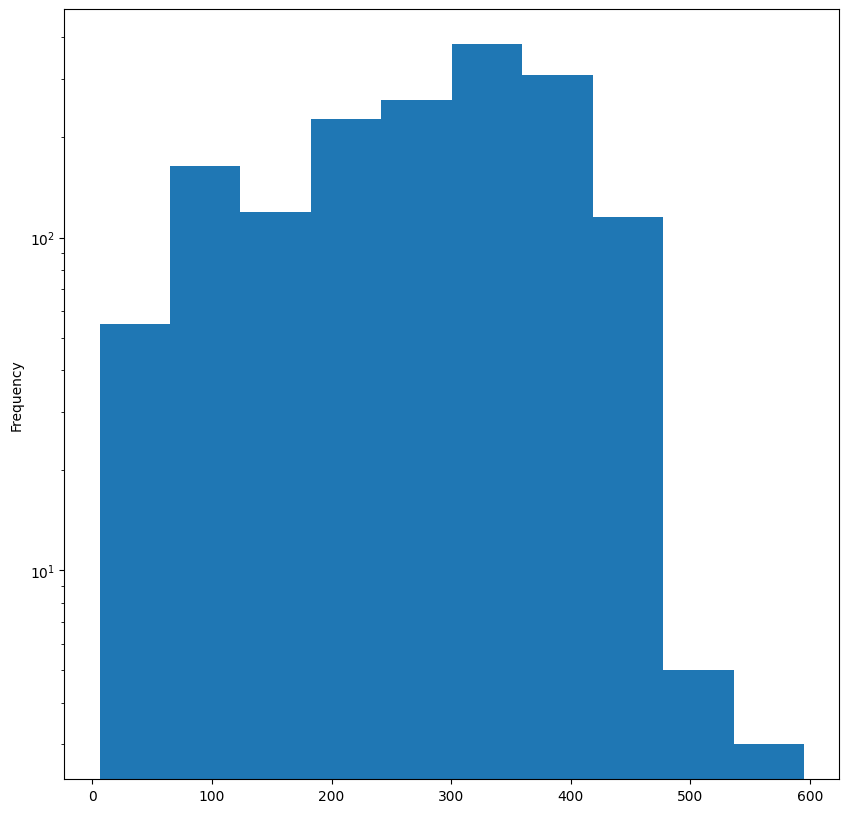

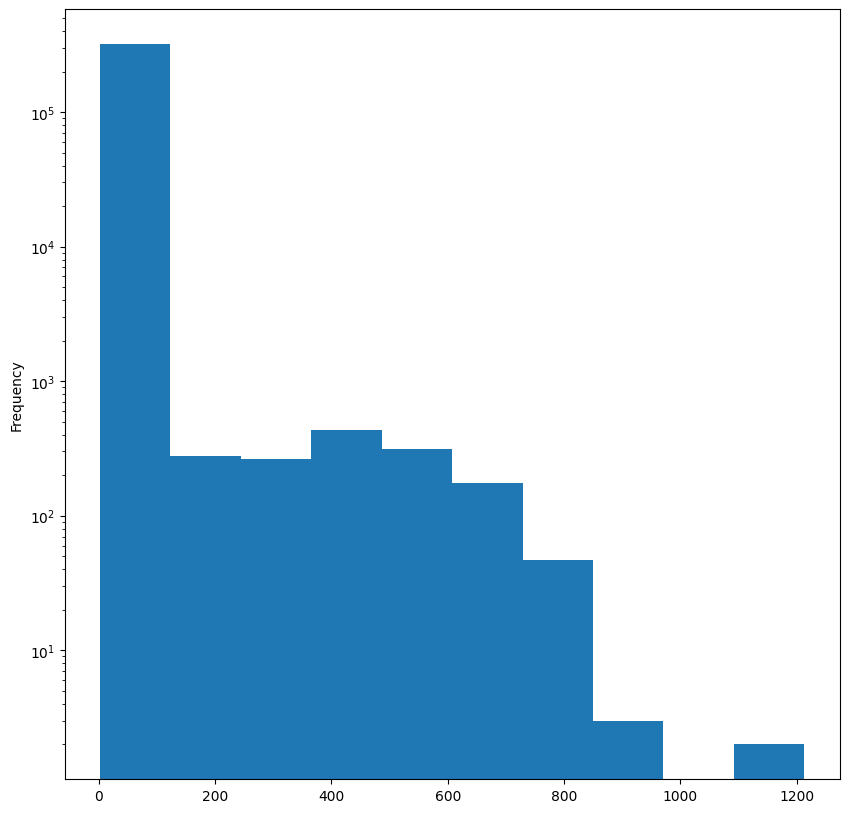

In [15]:
for G in [G_bu, G_tu]:
    plt.figure(figsize=(10,10))
    degrees = pd.Series({k:v for k, v in nx.degree(G)})
    degrees.plot.hist()
    plt.yscale("log")

-   x축: 노드의 연결도

-   y축: 로그 스케일(연결도가 큰 노드의 수가 매우 적으므로)

`-` 각 그래프 간선 가중치 분포

In [16]:
for G in [G_bu, G_tu]:
    allEdgeWeights = pd.Series({
        (d[0],d[1]):d[2]["weight"]  #d[0],d[1]을 key로 d[2]를 weight로
        #d는 G.edges(data=True)로 (u,v,data)형태의 튜플을 반복하는 반복문
        for d in G.edges(data=True)})
    np.quantile(allEdgeWeights.values,
               [0.10, 0.50, 0.70, 0.9])
    

In [17]:
np.quantile(allEdgeWeights.values,[0.10, 0.50, 0.70, 0.9])

`-` 매게 중심성 측정 지표

In [18]:
for G in [G_bu, G_tu]:
    plt.figure(figsize=(10,10))
    bc_distr = pd.Series(nx.betweenness_centrality(G))
    bc_distr.plot.hist()
    plt.yscale("log")

-   그래프 내에서 노드가 얼마나 중심적인 역할을 하는지 나타내는 지표

-   해당 노드가 얼마나 많은 최단경로에 포함되는지 살피기

-   노드가 많은 최단경로를 포함하면 해당노드의 매개중심성은 커진다.

`-` 상관계수

In [19]:
for G in [G_bu, G_tu]:
    print(nx.degree_pearson_correlation_coefficient(G))

-0.12467174727090688
-0.8051895351325623

-   음의 동류성(서로 다른 속성을 가진 노드들끼리 연결되어 있다.)

-   0~ -1 사이의 값을 가짐

-   -1에 가까울수록 서로 다른 속성을 가진 노드들끼리 강한 음의 상관관계

-   0에 가까울수록 노드들이 연결될 때 서로 다른 속성을 가진 노드들끼리
    큰 차이가 없음 =\>

-   연결도 높은 개인이 연골도 낮은 개인과 연관돼 있다.

-   이분그래프: 낮은 차수의 고객은 들어오는 트랜잭션 수가 많은 높은
    차수의 판매자와만 연결되어 상관계수가 낮다.

-   삼분그래프:동류성이 훨씬 더 낮다. 트랜잭션 노드가 있기 댸문에?

## 커뮤니티 감지

In [23]:
# pip install python-louvain

In [20]:
import networkx as nx
import community

In [21]:
import community
for G in [G_bu, G_tu]:
    parts = community.best_partition(G, random_state=42, weight='weight')

In [22]:
communities = pd.Series(parts)

In [23]:
communities

In [24]:
print(communities.value_counts().sort_values(ascending=False))

4      9426
94     6025
6      5835
42     5636
50     5016
       ... 
112    1341
91     1307
18     1104
62     1057
85      585
Length: 113, dtype: int64

-   커뮤니티 종류가 늘었따. 96\>\>113개로

-   커뮤니티 감지를 통해 특정 사기 패턴 식별

-   커뮤니티 추출 후 포함된 노드 수에 따라 정렬

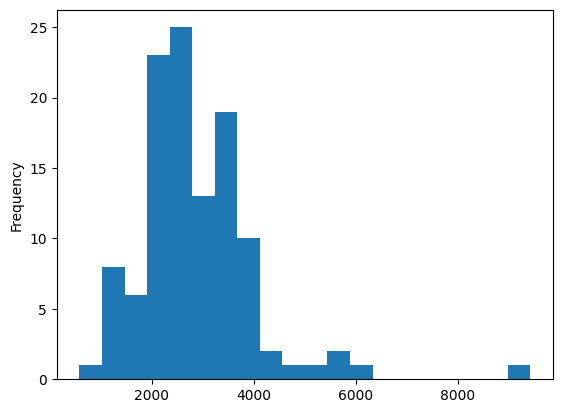

In [25]:
communities.value_counts().plot.hist(bins=20)

-   9426개 이상한거 하나있고.. 약간 2000~3000사이에 집중되어 보인다.

In [26]:
graphs = [] # 부분그래프 저장
d = {}  # 부정 거래 비율 저장 
for x in communities.unique():
    tmp = nx.subgraph(G, communities[communities==x].index)
    fraud_edges = sum(nx.get_edge_attributes(tmp, "label").values())
    ratio = 0 if fraud_edges == 0 else (fraud_edges/tmp.number_of_edges())*100
    d[x] = ratio
    graphs += [tmp]

pd.Series(d).sort_values(ascending=False)

-   사기 거래 비율 계산. 사기 거래가 집중된 특정 하위 그래프 식별

-   특정 커뮤니티에 포함된 노드를 사용하여 노드 유도 하위 그래프 생성

-   하위 그래프: 모든 간선 수에 대한 사기 거래 간선 수의 비율로 사기
    거래 백분율 계싼

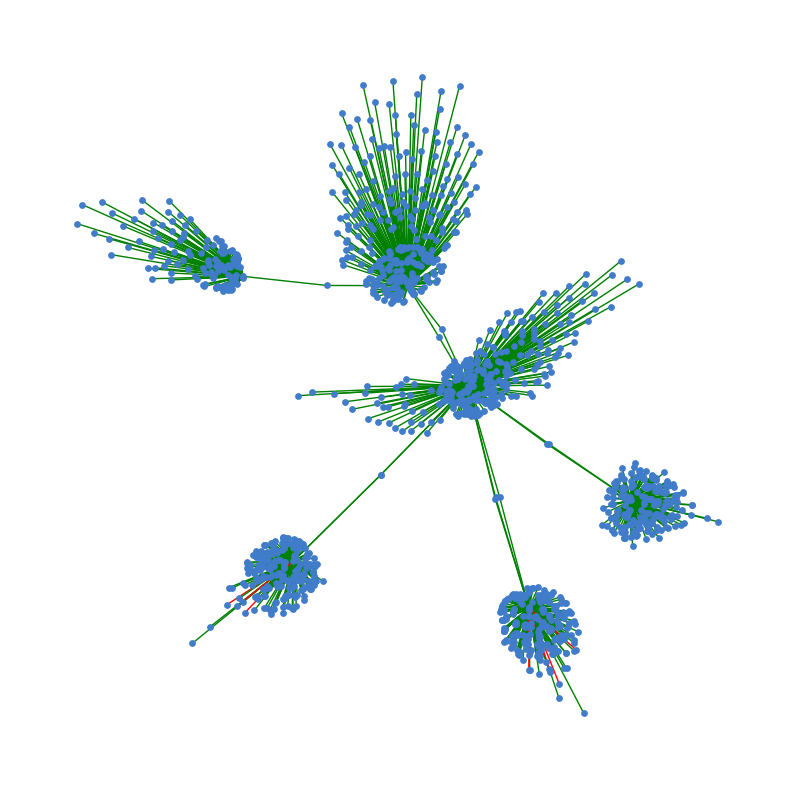

In [29]:
gId = 10
plt.figure(figsize=(10,10))
spring_pos = nx.spring_layout(graphs[gId])
plt.axis("off")
edge_colors = ["r" if x == 1 else "g" for x in nx.get_edge_attributes(graphs[gId], 'label').values()]  #r:빨간색, g:녹색
nx.draw_networkx(graphs[gId], pos=spring_pos, node_color=default_node_color, 
                 edge_color=edge_colors, with_labels=False, node_size=15)

-   커뮤니티 감지 알고리즘에 의해 감지된 노드 유도 하위 그래프 그리기

-   특정 커뮤니티 인덱스 gId가 주어지면 해당 커뮤니티에서 사용 가능한
    노드로 유도 하위 그래프 추출하고 얻는다.

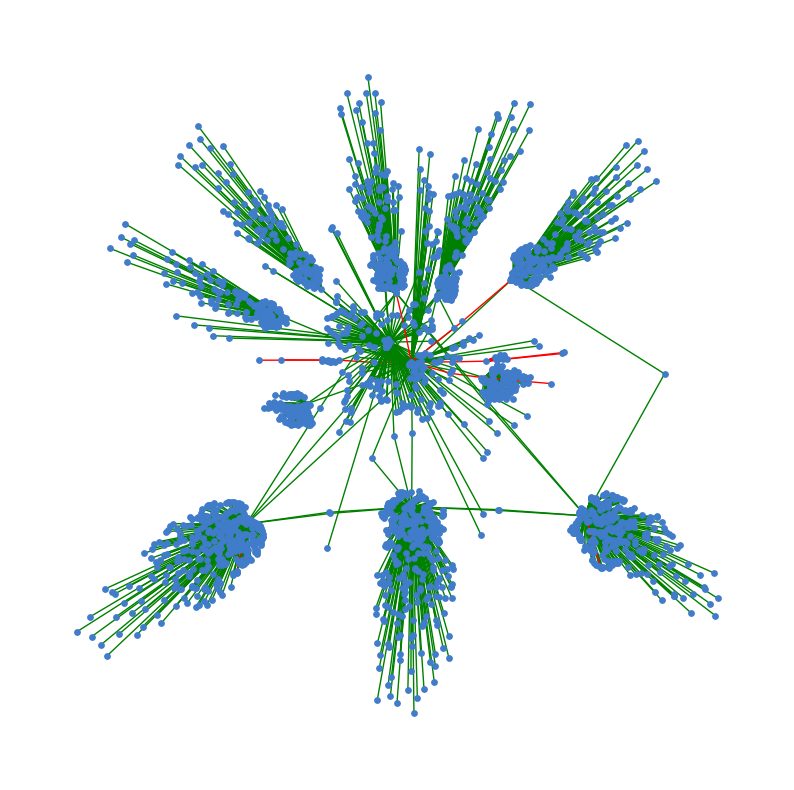

In [30]:
gId = 56
plt.figure(figsize=(10,10))
spring_pos = nx.spring_layout(graphs[gId])
plt.axis("off")
edge_colors = ["r" if x == 1 else "g" for x in nx.get_edge_attributes(graphs[gId], 'label').values()]  #r:빨간색, g:녹색
nx.draw_networkx(graphs[gId], pos=spring_pos, node_color=default_node_color, 
                 edge_color=edge_colors, with_labels=False, node_size=15)

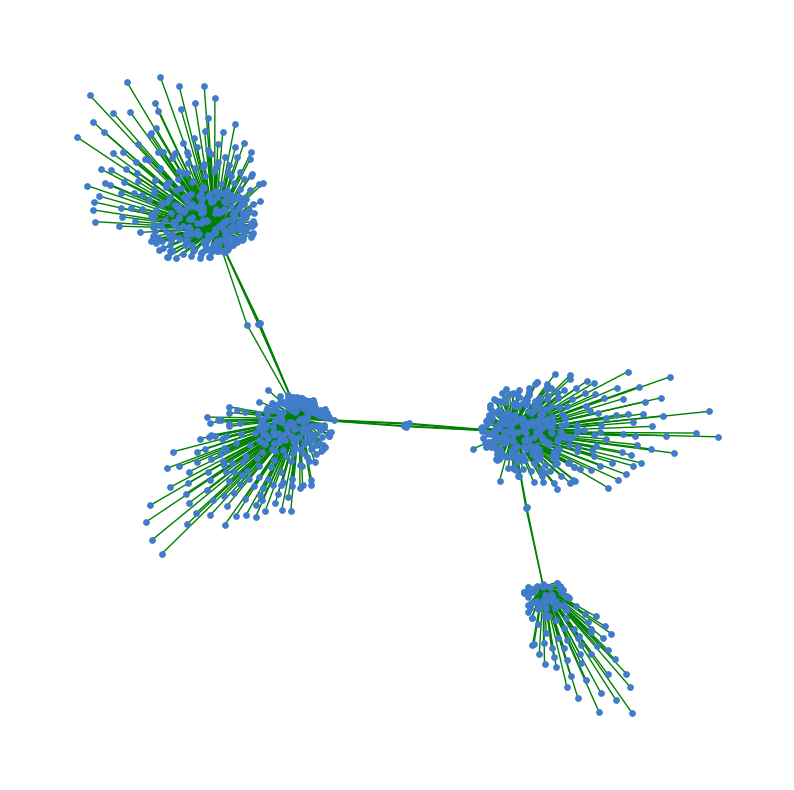

In [31]:
gId = 18
plt.figure(figsize=(10,10))
spring_pos = nx.spring_layout(graphs[gId])
plt.axis("off")
edge_colors = ["r" if x == 1 else "g" for x in nx.get_edge_attributes(graphs[gId], 'label').values()]  #r:빨간색, g:녹색
nx.draw_networkx(graphs[gId], pos=spring_pos, node_color=default_node_color, 
                 edge_color=edge_colors, with_labels=False, node_size=15)

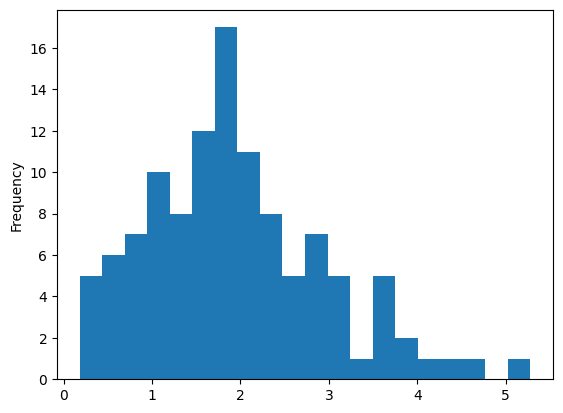

In [32]:
pd.Series(d).plot.hist(bins=20)

## 사기 탐지를 위한 지도 및 비지도 임베딩

-   트랜잭션 간선으로 표기

-   각 간선을 올바른 클래스(사기 또는 정상)으로 분류

### 지도학습

In [14]:
from sklearn.utils import resample

df_majority = df[df.is_fraud==0]
df_minority = df[df.is_fraud==1]

df_maj_dowsampled = resample(df_majority,
                             n_samples=len(df_minority),
                             random_state=42)

df_downsampled = pd.concat([df_minority, df_maj_dowsampled])

print(df_downsampled.is_fraud.value_counts())
G_down = build_graph_bipartite(df_downsampled)

1    6006
0    6006
Name: is_fraud, dtype: int64

In [46]:
df.shape

In [49]:
df_minority.shape

In [50]:
df_majority.shape

In [51]:
6006 / 312771 

-   무작위 언더샘플링 사용

-   소수 클래스(사기거래)이 샘플 수 와 일치시키려고 다수
    클래스(정상거래)의 하위 샘플을 가져옴

-   데이터 불균형을 처리하기 위해서

In [17]:
from sklearn.model_selection import train_test_split


train_edges, test_edges, train_labels, test_labels = train_test_split(list(range(len(G_down.edges))), 
                                                                      list(nx.get_edge_attributes(G_down, "label").values()), 
                                                                      test_size=0.20, 
                                                                      random_state=42)

In [18]:
edgs = list(G_down.edges)
train_graph = G_down.edge_subgraph([edgs[x] for x in train_edges]).copy()
train_graph.add_nodes_from(list(set(G_down.nodes) - set(train_graph.nodes)))

-   데이터 8:2 비율로 학습 검증

In [53]:
pip install node2vec

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 71.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 90.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 13.6 MB/s eta 0:00:00
  Attempting uninstall: networkx
    Found existing installation: networkx 3.0
    Uninstalling networkx-3.0:
      Successfully uninstalled networkx-3.0
Note: you may need to restart the kernel to use updated packages.

In [28]:
from node2vec import Node2Vec
from node2vec.edges import HadamardEmbedder, AverageEmbedder, WeightedL1Embedder, WeightedL2Embedder

node2vec_train = Node2Vec(train_graph, weight_key='weight')
model_train = node2vec_train.fit(window=10)

Generating walks (CPU: 1):   0%|          | 0/10 [00:00<?, ?it/s]Generating walks (CPU: 1): 100%|██████████| 10/10 [00:04<00:00,  2.45it/s]

-   Node2Vec 알고리즘 사용해 특징 공간 구축

In [35]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn import metrics 

classes = [HadamardEmbedder, AverageEmbedder, WeightedL1Embedder, WeightedL2Embedder]
for cl in classes:
    embeddings_train = cl(keyed_vectors=model_train.wv) 
    # 벡터스페이스 상에 edge를 투영.. 

    train_embeddings = [embeddings_train[str(edgs[x][0]), str(edgs[x][1])] for x in train_edges]
    test_embeddings = [embeddings_train[str(edgs[x][0]), str(edgs[x][1])] for x in test_edges]
    
    rf = RandomForestClassifier(n_estimators=1000, random_state=42) 
    rf.fit(train_embeddings, train_labels); 
    #
    y_hat = rf.predict_proba(test_embeddings)
    y_pred = np.argmax(yhat,axis=1)
    #y_pred = rf.predict(test_embeddings)
    print(cl)
    print('Precision:', metrics.precision_score(test_labels, y_pred)) 
    print('Recall:', metrics.recall_score(test_labels, y_pred)) 
    print('F1-Score:', metrics.f1_score(test_labels, y_pred)) 

<class 'node2vec.edges.HadamardEmbedder'>
Precision: 0.7236842105263158
Recall: 0.1407849829351536
F1-Score: 0.2357142857142857

In [36]:
y_pred

In [38]:
yhat = rf.predict_proba(test_embeddings)

In [44]:
yhat

-   Node2Vec 알고리즘 사용해 각 Edge2Vec 알고리즘으로 특징 공간 생성

-   sklearn 파이썬 라이브러리의 RandomForestClassifier은 이전 단계에서
    생성한 특징에 대해 학습

-   검증 테스트 위해 정밀도, 재현율, F1-score 성능 지표 측정

### 비지도학습

-   k-means 알고리즘 사용

-   지도학습과의 차이점은 특징 공간이 학습-검증 분할을 안함.

In [38]:
nod2vec_unsup = Node2Vec(G_down, weight_key='weight')
unsup_vals = nod2vec_unsup.fit(window=10)

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:04<00:00,  2.30it/s]

-   다운샘플링 절차에 전체 그래프 알고리즘 계산

In [39]:
from sklearn.cluster import KMeans

classes = [HadamardEmbedder, AverageEmbedder, WeightedL1Embedder, WeightedL2Embedder]
true_labels = [x for x in nx.get_edge_attributes(G_down, "label").values()]

for cl in classes:
    embedding_edge = cl(keyed_vectors=unsup_vals.wv) 

    embedding = [embedding_edge[str(x[0]), str(x[1])] for x in G_down.edges()]
    kmeans = KMeans(2, random_state=42).fit(embedding)
    
    
    nmi = metrics.adjusted_mutual_info_score(true_labels, kmeans.labels_)
    ho = metrics.homogeneity_score(true_labels, kmeans.labels_)
    co = metrics.completeness_score(true_labels, kmeans.labels_)
    vmeasure = metrics.v_measure_score(true_labels, kmeans.labels_)
    
    print(cl)
    print('NMI:', nmi)
    print('Homogeneity:', ho)
    print('Completeness:', co)
    print('V-Measure:', vmeasure)

/home/coco/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/coco/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/coco/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/coco/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warning

<class 'node2vec.edges.HadamardEmbedder'>
NMI: 0.04418691434534317
Homogeneity: 0.0392170155918133
Completeness: 0.05077340984619601
V-Measure: 0.044253187956299615
<class 'node2vec.edges.AverageEmbedder'>
NMI: 0.10945180042668563
Homogeneity: 0.10590886334115046
Completeness: 0.11336117407653773
V-Measure: 0.10950837820667877
<class 'node2vec.edges.WeightedL1Embedder'>
NMI: 0.17575054988974667
Homogeneity: 0.1757509360433583
Completeness: 0.17585150874409544
V-Measure: 0.17580120800977098
<class 'node2vec.edges.WeightedL2Embedder'>
NMI: 0.13740583375677415
Homogeneity: 0.13628828058562012
Completeness: 0.1386505946822449
V-Measure: 0.13745928896382234

`-` NMI(Normalized Mutual Information)

-   두 개의 군집 결과 비교

-   0~1이며 1에 가까울수록 높은 성능

`-` Homogeneity

-   하나의 실제 군집 내에서 같은 군집에 속한 샘플들이 군집화 결과에서
    같은 군집에 속할 비율

-   1에 가까울수록 높은 성능

`-` Completeness

-   하나의 예측 군집 내에서 같은 실제 군집에 속한 샘플들이 군집화
    결과에서 같은 군집에 속할 비율

-   0~1이며 1에 가까울수록 높은 성능

`-` V-measure

-   Homogeneity와 Completeness의 조화 평균

-   0~1이며 1에 가까울수록 높은 성능

-   비지도 학습에 이상치 탐지 방법

-   k-means/LOF/One-class SVM 등이 있다.. 한번 같이 해보자.

-   조금씩 다 커졌넹..

`-` 지도학습에서 정상거래에서 다운샘플링을 했는데

만약, 사기거래에서 업샘플링을 하게되면 어떻게 될까?